# Machine Learning Mini Project

### Dataset description, visualisation, and pre-processing

<div class="alert alert-block alert-warning">
The Frequent Pattern Mining for Enhanced Drug Prescription dataset focuses on patient characteristics, prescription data, and pharmacy inventory. Its main purpose is to identify patterns in frequently prescribed drugs using association rule mining methods. These patterns aim to improve drug prescription practices and optimize pharmacy inventory management, ensuring efficient resource allocation and better patient outcomes.
</div>


In [6]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from ydata_profiling import ProfileReport
from tqdm import tqdm
import pickle
from scipy import stats
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from pyECLAT import ECLAT
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=[15,6]

In [7]:
#1
data = pd.read_csv('medicine_prescription_records.csv')
data.head()

,Unnamed: 0,specialty,years_practicing,cms_prescription_counts
0,0,Nephrology,7,"DOXAZOSIN MESYLATE, MIDODRINE HCL, MEGESTROL A..."
1,1,General Practice,7,"CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAMINO..."
2,2,General Practice,7,"CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL"
3,3,General Practice,7,AMOXICILLIN
4,4,Nephrology,6,"PIOGLITAZONE HCL, BENAZEPRIL HCL, DIAZEPAM, HY..."


In [8]:
data.tail()

,Unnamed: 0,specialty,years_practicing,cms_prescription_counts
239925,239925,Family,7,"SIMVASTATIN, NEXIUM, CHLORHEXIDINE GLUCONATE, ..."
239926,239926,Surgical Technologist,2,"SANTYL, CLOPIDOGREL"
239927,239927,Psych/Mental Health,3,"HYDROXYZINE PAMOATE, BUSPIRONE HCL, SEROQUEL X..."
239928,239928,Family,2,"CIPROFLOXACIN HCL, AMOXICILLIN, IBUPROFEN, NEX..."
239929,239929,General Practice,7,"AMOXICILLIN, PENICILLIN V POTASSIUM"


In [9]:
#DS Summary/Infos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239930 entries, 0 to 239929
Data columns (total 4 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Unnamed: 0               239930 non-null  int64 
 1   specialty                239930 non-null  object
 2   years_practicing         239930 non-null  int64 
 3   cms_prescription_counts  239930 non-null  object
dtypes: int64(2), object(2)
memory usage: 7.3+ MB


In [10]:
data.shape

(239930, 4)

In [11]:
data.describe()

,Unnamed: 0,years_practicing
count,239930.000000,239930.000000
mean,119964.500000,6.241875
std,69261.969381,1.649269
min,0.000000,1.000000
25%,59982.250000,6.000000
50%,119964.500000,7.000000
75%,179946.750000,7.000000
max,239929.000000,8.000000


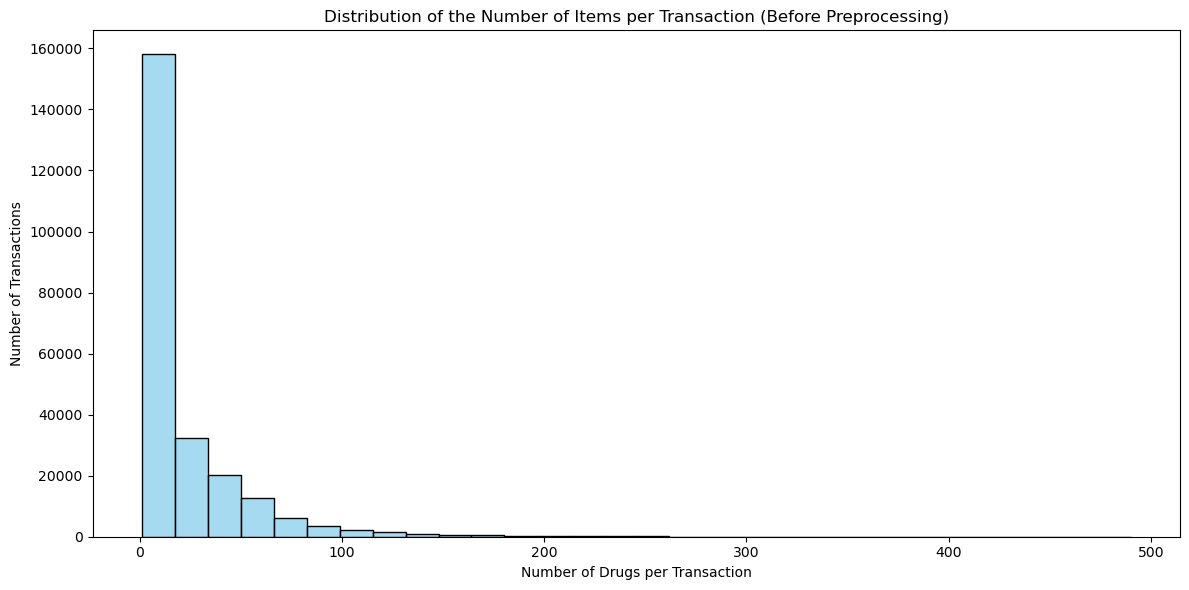

In [12]:
# Calculate the number of drugs per transaction
data['num_drugs'] = data['cms_prescription_counts'].apply(lambda x: len(x.split(',')))

# Plot distribution of the number of items per transaction before preprocessing
plt.figure(figsize=(12, 6))
sns.histplot(data['num_drugs'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of the Number of Items per Transaction (Before Preprocessing)')
plt.xlabel('Number of Drugs per Transaction')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.savefig('transactions_distribution.png')
plt.show()

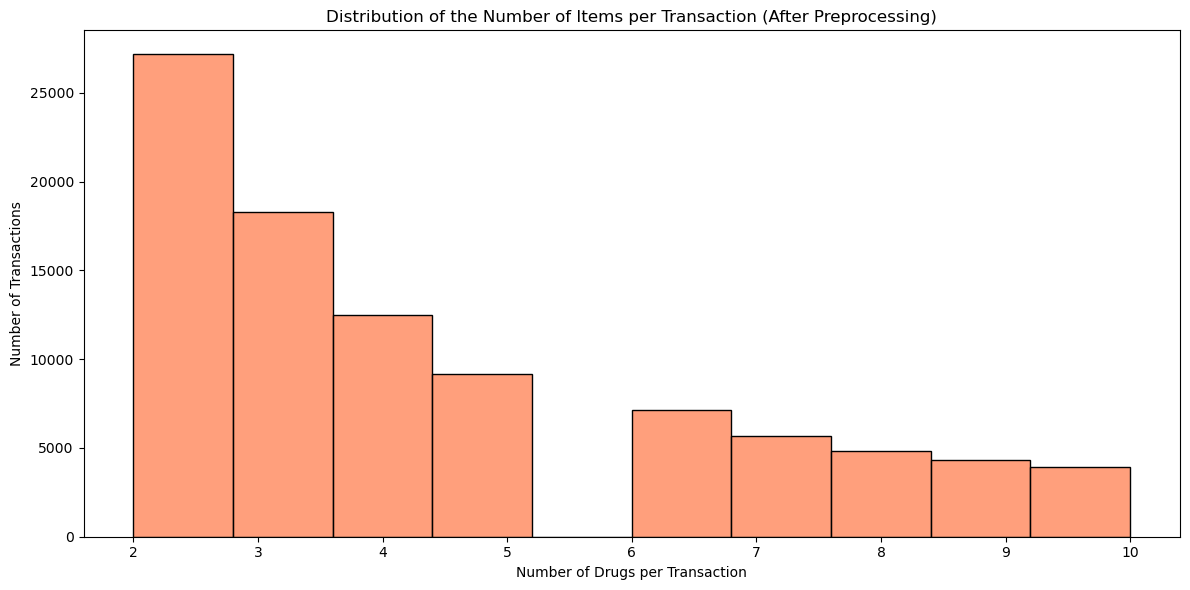

In [13]:
# Filter data: Remove transactions with fewer than 2 or more than 10 drugs
filtered_data = data[(data['num_drugs'] >= 2) & (data['num_drugs'] <= 10)]

# Plot distribution of the number of items per transaction after preprocessing
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['num_drugs'], bins=10, kde=False, color='coral')
plt.title('Distribution of the Number of Items per Transaction (After Preprocessing)')
plt.xlabel('Number of Drugs per Transaction')
plt.ylabel('Number of Transactions')
plt.tight_layout()
plt.savefig('filtered_transactions_distribution.png')
plt.show()

In [14]:
#Splitting drugs
data['drug_list'] = data['cms_prescription_counts'].apply(lambda x: [drug.strip() for drug in x.split(',')])
data.head()

,Unnamed: 0,specialty,years_practicing,cms_prescription_counts,num_drugs,drug_list
0,0,Nephrology,7,"DOXAZOSIN MESYLATE, MIDODRINE HCL, MEGESTROL A...",68,"[DOXAZOSIN MESYLATE, MIDODRINE HCL, MEGESTROL ..."
1,1,General Practice,7,"CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAMINO...",3,"[CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAMIN..."
2,2,General Practice,7,"CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL",3,"[CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL]"
3,3,General Practice,7,AMOXICILLIN,1,[AMOXICILLIN]
4,4,Nephrology,6,"PIOGLITAZONE HCL, BENAZEPRIL HCL, DIAZEPAM, HY...",53,"[PIOGLITAZONE HCL, BENAZEPRIL HCL, DIAZEPAM, H..."


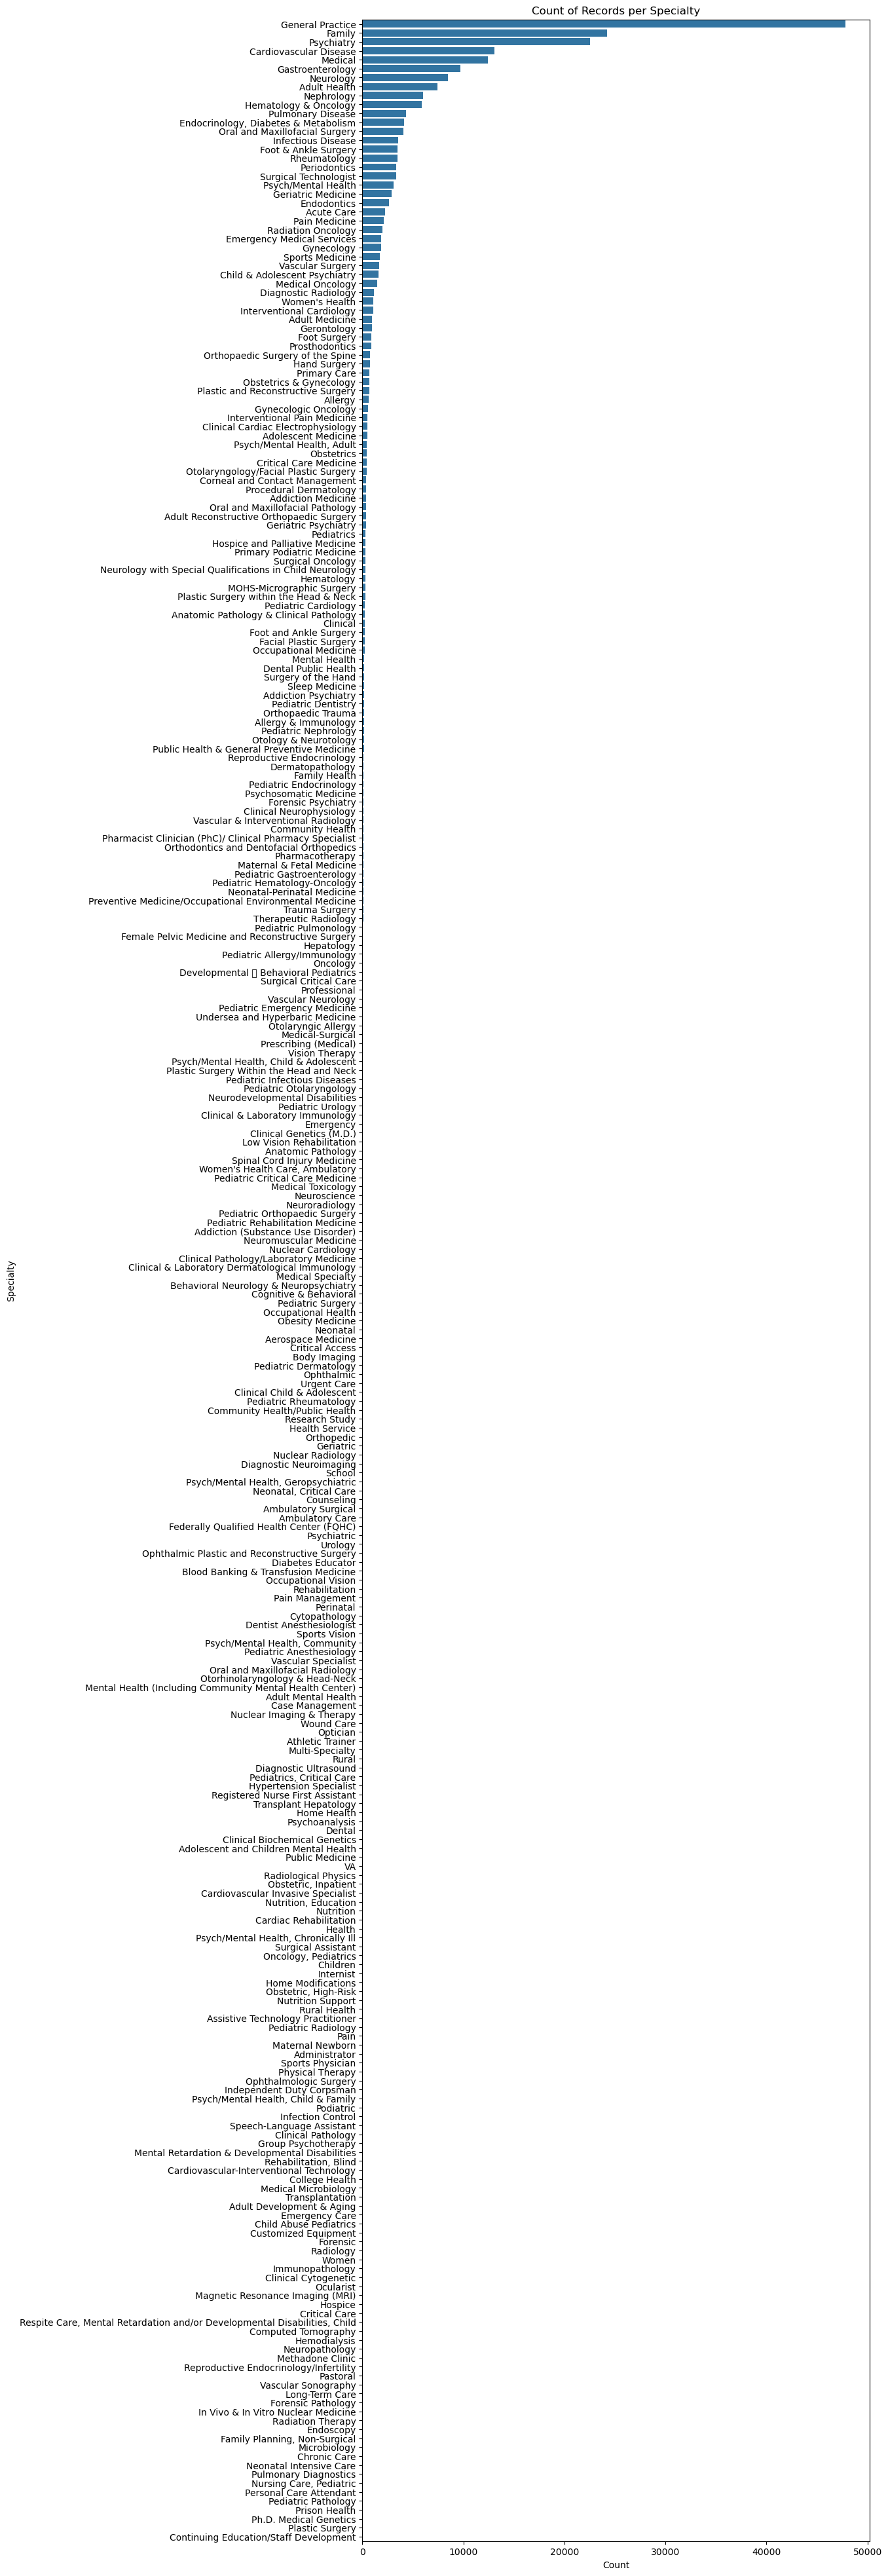

In [15]:
# Example visualization: Count of unique specialties
plt.figure(figsize=(10, 50))
sns.countplot(data=data, y='specialty', order=data['specialty'].value_counts().index)
plt.title('Count of Records per Specialty')
plt.xlabel('Count')
plt.ylabel('Specialty')
plt.show()

In [16]:
#WE SEE THAT MANY SPECIALITIES HAVE VERY FEW RECORDS, WE WILL DROP SPECIALITIES WITH LESS THAN 100 RECORDS
# Drop specialties with less than 100 records
specialties_to_drop = [specialty for specialty, count in data['specialty'].value_counts().items() if count < 100]
data = data[~data['specialty'].isin(specialties_to_drop)]


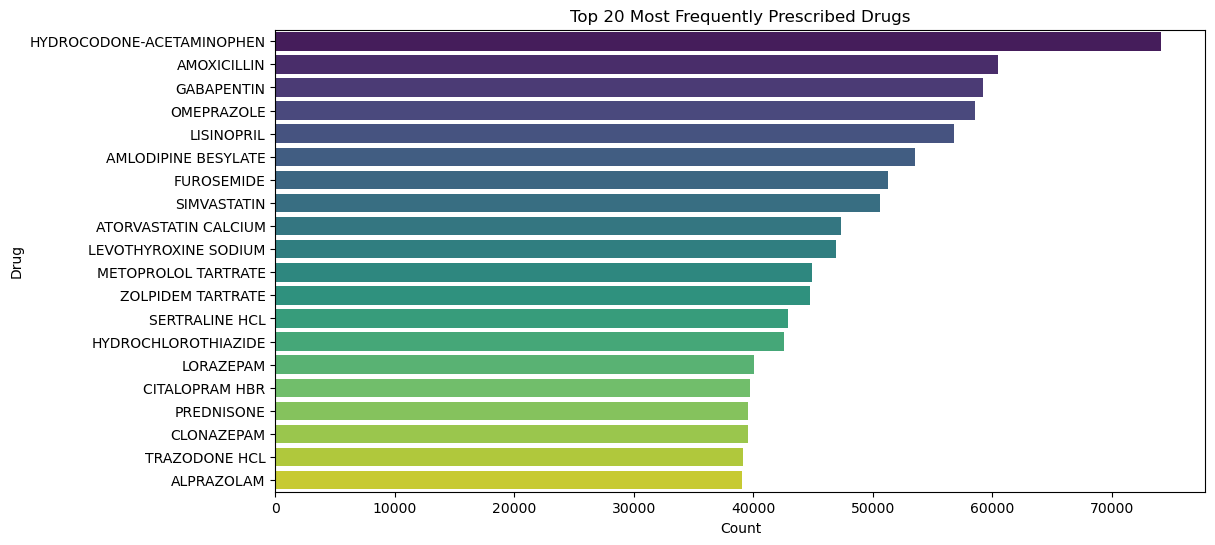

In [17]:
from collections import Counter

# Flatten the list of drugs
all_drugs = [drug for sublist in data['drug_list'] for drug in sublist]

# Count occurrences
drug_counts = Counter(all_drugs)
top_drugs = drug_counts.most_common(20)

# Create a DataFrame for visualization
drug_df = pd.DataFrame(top_drugs, columns=['Drug', 'Count'])

# Bar plot of the top 20 drugs
plt.figure(figsize=(12, 6))
sns.barplot(data=drug_df, x='Count', y='Drug', palette='viridis')
plt.title('Top 20 Most Frequently Prescribed Drugs')
plt.xlabel('Count')
plt.ylabel('Drug')
plt.show()


In [18]:
#Count distinct drugs Before filtering
distinct_drugs = set([drug for sublist in data['drug_list'] for drug in sublist])

print("Number of distinct frequent drugs:", len(distinct_drugs))

Number of distinct frequent drugs: 2388


In [19]:
# Filter drugs appearing in fewer than 100 transactions
drug_counts = data['drug_list'].explode().value_counts()
frequent_drugs = drug_counts[drug_counts >= 100].index

# Filter transactions to include only frequent drugs
data['filtered_drug_list'] = data['drug_list'].apply(
    lambda x: [drug for drug in x if drug in frequent_drugs]
)

In [20]:
#Count distinct drugs After filtering
distinct_drugs = set([drug for sublist in data['filtered_drug_list'] for drug in sublist])

print("Number of distinct frequent drugs after filtring:", len(distinct_drugs))

Number of distinct frequent drugs after filtring: 1041


In [19]:
#FP_Growth just too +16hours training

In [21]:
#Sampling Data and move to test the E-CLAT Algorithm

# Sample 5000 random rows
sample_data = data.sample(n=5000, random_state=42)

# Ensure the data format matches expected input (list of lists)
sample_drug_list = sample_data['filtered_drug_list']

In [22]:
#ECLAT ALGORITHM
# Create vertical database
from collections import defaultdict


def create_vertical_database(data):
    vertical_db = defaultdict(set)
    for idx, drugs in enumerate(data):
        for drug in drugs:
            vertical_db[drug].add(idx)
    return vertical_db

# ECLAT algorithm to find frequent itemsets
def eclat(vertical_db, min_support):
    def recursive_eclat(prefix, itemsets):
        for item, tid_set in itemsets.items():
            new_prefix = prefix | {item}
            support = len(tid_set)
            if support >= min_support:
                frequent_itemsets.append((new_prefix, support))
                # Generate new itemsets by intersecting TID sets
                new_itemsets = {
                    other_item: tid_set & other_tid_set
                    for other_item, other_tid_set in itemsets.items()
                    if other_item > item
                }
                recursive_eclat(new_prefix, new_itemsets)

    frequent_itemsets = []
    recursive_eclat(set(), vertical_db)
    return frequent_itemsets

### Dataset pre-processing

In [23]:
# Preprocess full dataset - filter drugs appearing less than 100 times
drug_counts_full = data['drug_list'].explode().value_counts()
frequent_drugs_full = drug_counts_full[drug_counts_full >= 100].index

# Filter transactions to include only frequent drugs in the full dataset
data['filtered_drug_list'] = data['drug_list'].apply(
    lambda x: [drug for drug in x if drug in frequent_drugs_full]
)

# Filter out transactions with more than 10 drugs or fewer than 2 drugs in the full dataset ||NEW DATASET CONTAINS 91000 ROWS
data_filtered_full = data[data['filtered_drug_list'].apply(lambda x: 2 <= len(x) <= 10)]

In [24]:
#Sampling Data and move to test the E-CLAT Algorithm

# Sample 5000 random rows
sample_data = data.sample(n=1000, random_state=42)

# Ensure the data format matches expected input (list of lists)
sample_drug_list = sample_data['filtered_drug_list']

In [25]:
# Preprocess sample dataset - filter drugs appearing less than 100 times
drug_counts_sample = sample_data['drug_list'].explode().value_counts()
frequent_drugs_sample = drug_counts_sample[drug_counts_sample >= 100].index

# Filter transactions to include only frequent drugs in the sample dataset
sample_data['filtered_drug_list'] = sample_data['drug_list'].apply(
    lambda x: [drug for drug in x if drug in frequent_drugs_sample]
)

# Filter out transactions with more than 10 drugs or fewer than 2 drugs in the sample dataset
sample_data_filtered = sample_data[sample_data['filtered_drug_list'].apply(lambda x: 2 <= len(x) <= 10)]


In [26]:
data_filtered_full.head()

,Unnamed: 0,specialty,years_practicing,cms_prescription_counts,num_drugs,drug_list,filtered_drug_list
1,1,General Practice,7,"CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAMINO...",3,"[CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAMIN...","[CEPHALEXIN, AMOXICILLIN, HYDROCODONE-ACETAMIN..."
2,2,General Practice,7,"CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL",3,"[CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL]","[CEPHALEXIN, AMOXICILLIN, CLINDAMYCIN HCL]"
5,5,General Practice,7,"AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN, OXYCOD...",5,"[AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN, OXYCO...","[AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN, OXYCO..."
6,6,General Practice,4,"AMOXICILLIN, CLINDAMYCIN HCL, IBUPROFEN",3,"[AMOXICILLIN, CLINDAMYCIN HCL, IBUPROFEN]","[AMOXICILLIN, CLINDAMYCIN HCL, IBUPROFEN]"
10,10,Psychiatry,6,"CYMBALTA, RISPERIDONE, ZOLPIDEM TARTRATE, BUPR...",5,"[CYMBALTA, RISPERIDONE, ZOLPIDEM TARTRATE, BUP...","[CYMBALTA, RISPERIDONE, ZOLPIDEM TARTRATE, BUP..."


In [27]:
data_filtered_full.shape

(91420, 7)

In [28]:
sample_data_filtered.head()
#calculate the max number of drugs in filtred_drug_list
sample_data_filtered["filtered_drug_list"].value_counts()


filtered_drug_list
[AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN]                                                                     42
[AMOXICILLIN, IBUPROFEN]                                                                                     11
[OMEPRAZOLE, NEXIUM, PANTOPRAZOLE SODIUM]                                                                     5
[AZITHROMYCIN, AMOXICILLIN]                                                                                   4
[AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN, IBUPROFEN]                                                           4
                                                                                                             ..
[HYDROCODONE-ACETAMINOPHEN, LORAZEPAM, PREDNISONE, ALENDRONATE SODIUM]                                        1
[GABAPENTIN, PAROXETINE HCL]                                                                                  1
[HYDROCHLOROTHIAZIDE, CIPROFLOXACIN HCL, AZITHROMYCIN]                               

In [29]:
# Apply ECLAT on full dataset
vertical_db_full = create_vertical_database(data_filtered_full['filtered_drug_list'])
frequent_itemsets_full = eclat(vertical_db_full, min_support=455)

# Convert results to DataFrame for full dataset
frequent_itemsets_full_df = pd.DataFrame(frequent_itemsets_full, columns=["itemset", "support"])
frequent_itemsets_full_df["itemset"] = frequent_itemsets_full_df["itemset"].apply(lambda x: list(x))

# Save ECLAT model for full dataset
with open('eclat_model_full_dataset.pkl', 'wb') as f:
    pickle.dump(frequent_itemsets_full_df, f)



In [140]:
frequent_itemsets_full_df.head()

,itemset,support
0,[CEPHALEXIN],8384
1,"[CEPHALEXIN, HYDROCODONE-ACETAMINOPHEN]",4981
2,"[CEPHALEXIN, OXYCODONE-ACETAMINOPHEN, HYDROCOD...",972
3,"[CEPHALEXIN, IBUPROFEN, HYDROCODONE-ACETAMINOP...",655
4,"[PREDNISONE, CEPHALEXIN, HYDROCODONE-ACETAMINO...",675


In [30]:
frequent_itemsets_full_df["support"]= frequent_itemsets_full_df["support"]/91000

In [32]:
frequent_itemsets_full_df.shape

(519, 2)

In [34]:
#Droping rows that contains just one item
#frequent_itemsets_full_df2 = frequent_itemsets_full_df[frequent_itemsets_full_df["itemset"].apply (lambda x : 2<= len(x)<10)]
#Normalize Support
#frequent_itemsets_full_df2["support"] = frequent_itemsets_full_df2["support"]/ data_filtered_full.__len__()
#Displaying itemsets of Eclat model on full dataset
frequent_itemsets_full_df.head()

,itemset,support
0,[CEPHALEXIN],0.092132
1,"[CEPHALEXIN, HYDROCODONE-ACETAMINOPHEN]",0.054736
2,"[OXYCODONE-ACETAMINOPHEN, CEPHALEXIN, HYDROCOD...",0.010681
3,"[CEPHALEXIN, IBUPROFEN, HYDROCODONE-ACETAMINOP...",0.007198
4,"[PREDNISONE, CEPHALEXIN, HYDROCODONE-ACETAMINO...",0.007418


In [35]:
# Apply ECLAT on sample dataset
vertical_db_sample = create_vertical_database(sample_data_filtered['filtered_drug_list'])
frequent_itemsets_sample = eclat(vertical_db_sample, min_support=25)

# Convert results to DataFrame for sample dataset
frequent_itemsets_sample_df = pd.DataFrame(frequent_itemsets_sample, columns=["itemset", "support"])
frequent_itemsets_sample_df["itemset"] = frequent_itemsets_sample_df["itemset"].apply(lambda x: list(x))

# Save the ECLAT model for the sample dataset
with open('eclat_model_sample_dataset.pkl', 'wb') as f:
    pickle.dump(frequent_itemsets_sample_df, f)

In [36]:
#ECLAT SAMPLE FREQUENT ITEMSETS DF 
frequent_itemsets_sample_df.head()
#droping rows that contains just one item in itemset
frequent_itemsets_sample_df2 = frequent_itemsets_sample_df[frequent_itemsets_sample_df["itemset"].apply (lambda x : 2<= len(x)<10)]
#Normalize Support
frequent_itemsets_sample_df2["support"] = frequent_itemsets_sample_df2["support"]/ 5000

In [37]:
#Displaying itemsets of Eclat model on sample dataset
frequent_itemsets_sample_df2.head()

,itemset,support
1,"[PANTOPRAZOLE SODIUM, OMEPRAZOLE]",0.0066
9,"[IBUPROFEN, HYDROCODONE-ACETAMINOPHEN]",0.0056
10,"[TRAMADOL HCL, HYDROCODONE-ACETAMINOPHEN]",0.0056
11,"[PREDNISONE, HYDROCODONE-ACETAMINOPHEN]",0.0066
14,"[AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN]",0.0126


In [47]:
#Pre-processing data to train PyECLAT / since it takes a dataframe of [drug1 , drug2 , drug3 , ...]
max_len_sample = max(len(lst) for lst in sample_data_filtered['filtered_drug_list'])
max_len_full=max(len(lst) for lst in data_filtered_full['filtered_drug_list'])
# Pad the lists with NaN to make them equal in length
padded_data_sample = [lst + [np.nan] * (max_len_sample - len(lst)) for lst in sample_data_filtered['filtered_drug_list']]
padded_data_full = [lst + [np.nan] * (max_len_full - len(lst)) for lst in data_filtered_full['filtered_drug_list']]
df_pyeclat_sample = pd.DataFrame(padded_data_sample)
df_pyeclat_full = pd.DataFrame(padded_data_full)

In [48]:
df_pyeclat_sample.head()

,0,1,2,3,4,5,6,7,8,9
0,OMEPRAZOLE,FUROSEMIDE,ATORVASTATIN CALCIUM,LOSARTAN POTASSIUM,CARVEDILOL,POTASSIUM CHLORIDE,AMLODIPINE BESYLATE,METOPROLOL TARTRATE,LISINOPRIL,METOPROLOL SUCCINATE
1,IBUPROFEN,HYDROCODONE-ACETAMINOPHEN,TRAMADOL HCL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AMOXICILLIN,IBUPROFEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AMOXICILLIN,HYDROCODONE-ACETAMINOPHEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AMOXICILLIN,HYDROCODONE-ACETAMINOPHEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_pyeclat_full.head()

,0,1,2,3,4,5,6,7,8,9
0,CEPHALEXIN,AMOXICILLIN,HYDROCODONE-ACETAMINOPHEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CEPHALEXIN,AMOXICILLIN,CLINDAMYCIN HCL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AMOXICILLIN,HYDROCODONE-ACETAMINOPHEN,OXYCODONE-ACETAMINOPHEN,CLINDAMYCIN HCL,PENICILLIN V POTASSIUM,NaN,NaN,NaN,NaN,NaN
3,AMOXICILLIN,CLINDAMYCIN HCL,IBUPROFEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CYMBALTA,RISPERIDONE,ZOLPIDEM TARTRATE,BUPROPION HCL SR,CLONAZEPAM,NaN,NaN,NaN,NaN,NaN


In [52]:
# Apply PyECLAT on sample dataset
eclat_sample = ECLAT(data=df_pyeclat_sample,verbose=True)
frequent_itemsets_sample_pyeclat, _ = eclat_sample.fit(min_support=0.05, min_combination=2, max_combination=5)

# Convert results to DataFrame for sample dataset (PyECLAT)
frequent_itemsets_sample_pyeclat_df = pd.DataFrame(frequent_itemsets_sample_pyeclat, columns=["itemset", "support"])

# Save the PyECLAT model for the sample dataset
with open('pyeclat_model_sample_dataset.pkl', 'wb') as f:
    pickle.dump(frequent_itemsets_sample_pyeclat_df, f)

100%|██████████| 47/47 [00:00<00:00, 1455.81it/s]


Combination 2 by 2


528it [00:04, 110.90it/s]


Combination 3 by 3


5456it [00:43, 124.30it/s]


Combination 4 by 4


13256it [02:36, 128.46it/s]

In [51]:
#head results of PyECLAT model
frequent_itemsets_sample_pyeclat_df.head()

,itemset,support


In [ ]:

# Apply PyECLAT on full dataset
eclat_full= ECLAT(data=df_pyeclat_full,verbose=True)
frequent_itemsets_full_pyeclat, _ = eclat_full.fit(min_support=0.1, min_combination=2, max_combination=5)

# Convert results to DataFrame for sample dataset (PyECLAT)
frequent_itemsets_full_pyeclat_df = pd.DataFrame(frequent_itemsets_full_pyeclat, columns=["itemset", "support"])

# Save the PyECLAT model for the sample dataset
with open('pyeclat_model_sample_dataset.pkl', 'wb') as f:
    pickle.dump(frequent_itemsets_full_pyeclat_df, f)


In [38]:

# Prepare data for FPGrowth (one-hot encoding for both datasets)
full_data_onehot = pd.DataFrame(
    data_filtered_full['filtered_drug_list'].apply(lambda x: pd.Series(1, index=x)).fillna(0)
)
sample_data_onehot = pd.DataFrame(
    sample_data_filtered['filtered_drug_list'].apply(lambda x: pd.Series(1, index=x)).fillna(0)
)





In [39]:
# Apply FPGrowth on sample dataset
frequent_itemsets_sample_fpgrowth = fpgrowth(sample_data_onehot, min_support=0.005, use_colnames=True)


# Save FPGrowth model for sample dataset
with open('fpgrowth_model_sample_dataset.pkl', 'wb') as f:
    pickle.dump(frequent_itemsets_sample_fpgrowth, f)


In [46]:
#Droping itemsets containing 1 item
frequent_itemsets_sample_fpgrowth2 =frequent_itemsets_sample_fpgrowth[frequent_itemsets_sample_fpgrowth["itemsets"].apply(lambda x: 2<=len(x)<10)]

In [47]:
frequent_itemsets_sample_fpgrowth2.head()

,support,itemsets
47,0.056980,"(HYDROCODONE-ACETAMINOPHEN, OMEPRAZOLE)"
48,0.017094,"(AMOXICILLIN, OMEPRAZOLE)"
49,0.034188,"(FUROSEMIDE, OMEPRAZOLE)"
50,0.037037,"(PREDNISONE, FUROSEMIDE)"
51,0.037037,"(FUROSEMIDE, HYDROCODONE-ACETAMINOPHEN)"


In [40]:
# Apply FPGrowth on full dataset
frequent_itemsets_full_fpgrowth = fpgrowth(full_data_onehot, min_support=0.005, use_colnames=True)


# Save FPGrowth model for sample dataset
with open('fpgrowth_model_sample_dataset.pkl', 'wb') as f:
    pickle.dump(frequent_itemsets_sample_fpgrowth, f)


In [49]:
frequent_itemsets_full_fpgrowth2 =frequent_itemsets_full_fpgrowth[frequent_itemsets_full_fpgrowth["itemsets"].apply(lambda x: 2<=len(x)<10)]

In [50]:
frequent_itemsets_full_fpgrowth2.head()

,support,itemsets
147,0.163564,"(AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN)"
148,0.054485,"(CEPHALEXIN, HYDROCODONE-ACETAMINOPHEN)"
149,0.032476,"(AMOXICILLIN, CEPHALEXIN)"
150,0.017677,"(CEPHALEXIN, CLINDAMYCIN HCL)"
151,0.008280,"(CEPHALEXIN, CHLORHEXIDINE GLUCONATE)"


### Models Loading

In [41]:
# Load ECLAT model for full dataset
with open('eclat_model_full_dataset.pkl', 'rb') as f:
    eclat_full_model = pickle.load(f)

# Load ECLAT model for sample dataset
with open('eclat_model_sample_dataset.pkl', 'rb') as f:
    eclat_sample_model = pickle.load(f)

# Load PyECLAT model for full dataset ####################PyEcLAT need time ####################
#with open('pyeclat_model_full_dataset.pkl', 'rb') as f:
    #pyeclat_full_model = pickle.load(f)

# Load PyECLAT model for sample dataset
#with open('pyeclat_model_sample_dataset.pkl', 'rb') as f:
    #pyeclat_sample_model = pickle.load(f)

# Load FPGrowth model for full dataset
with open('fpgrowth_model_full_dataset.pkl', 'rb') as f:
    fpgrowth_full_model = pickle.load(f)

# Load FPGrowth model for sample dataset
with open('fpgrowth_model_sample_dataset.pkl', 'rb') as f:
    fpgrowth_sample_model = pickle.load(f)


# Load Apriori model for full dataset
with open('apriori_trained_model.pkl', 'rb') as f:
    apriori_full_model = pickle.load(f)


### Models Evaluation

In [42]:
# Define a function to evaluate and display frequent itemsets
def evaluate_model(frequent_itemsets, model_name, top_n=10):
    print(f"--- {model_name} ---")
    print(f"Total Frequent Itemsets: {len(frequent_itemsets)}")
    print(f"Top {top_n} Frequent Itemsets by Support:")
    display(frequent_itemsets.nlargest(top_n, 'support'))
    print("\n")

# Evaluate FPGrowth models
evaluate_model(frequent_itemsets_full_fpgrowth, "FPGrowth - Full Dataset")

# Evaluate ECLAT models
evaluate_model(frequent_itemsets_full_df, "ECLAT - Full Dataset")

# Optional: Additional analysis (e.g., support threshold filtering)
def filter_by_support(frequent_itemsets, min_support):
    return frequent_itemsets[frequent_itemsets['support'] >= min_support]



--- FPGrowth - Full Dataset ---
Total Frequent Itemsets: 516
Top 10 Frequent Itemsets by Support:


,support,itemsets
0,0.353610,(HYDROCODONE-ACETAMINOPHEN)
1,0.337814,(AMOXICILLIN)
147,0.163564,"(AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN)"
3,0.155043,(CLINDAMYCIN HCL)
158,0.132225,"(CLINDAMYCIN HCL, AMOXICILLIN)"
12,0.124841,(CHLORHEXIDINE GLUCONATE)
223,0.108248,"(CHLORHEXIDINE GLUCONATE, AMOXICILLIN)"
2,0.091709,(CEPHALEXIN)
6,0.091424,(IBUPROFEN)
159,0.082236,"(CLINDAMYCIN HCL, HYDROCODONE-ACETAMINOPHEN)"




--- ECLAT - Full Dataset ---
Total Frequent Itemsets: 519
Top 10 Frequent Itemsets by Support:


,itemset,support
73,[HYDROCODONE-ACETAMINOPHEN],0.355242
23,[AMOXICILLIN],0.339374
29,"[AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN]",0.164319
108,[CLINDAMYCIN HCL],0.155758
34,"[CLINDAMYCIN HCL, AMOXICILLIN]",0.132835
149,[CHLORHEXIDINE GLUCONATE],0.125418
47,"[CHLORHEXIDINE GLUCONATE, AMOXICILLIN]",0.108747
0,[CEPHALEXIN],0.092132
124,[IBUPROFEN],0.091846
109,"[CLINDAMYCIN HCL, HYDROCODONE-ACETAMINOPHEN]",0.082615


In [ ]:
frequent_itemsets_full_df = pd.DataFrame({
    "itemsets": frequent_itemsets_full_df["itemset"],
    "support": frequent_itemsets_full_df["support"]   # normalize
})

In [46]:
def evaluate_models(full_fpgrowth, full_eclat,full_apriori):
    def summarize_model(name, frequent_itemsets, metric="support"):
        """
        Summarize the evaluation metrics for a model.
        """
        total_itemsets = len(frequent_itemsets)
        max_support = frequent_itemsets[metric].max()
        avg_support = frequent_itemsets[metric].mean()
        print(f"--- {name} ---")
        print(f"Total Frequent Itemsets: {total_itemsets}")
        print(f"Maximum Support: {max_support:.4f}")
        print(f"Average Support: {avg_support:.4f}")
        print("\n")
        return {"name": name, "total_itemsets": total_itemsets, "max_support": max_support, "avg_support": avg_support}

    # Evaluate models
    metrics = []
    metrics.append(summarize_model("FPGrowth - Full", full_fpgrowth))
    metrics.append(summarize_model("ECLAT - Full", full_eclat, metric="support"))
    metrics.append(summarize_model("Apriori - Full", full_eclat, metric="support"))

    # Compare metrics
    metrics_df = pd.DataFrame(metrics)
    print("--- Model Comparison ---")
    display(metrics_df)

    # Select the best model based on highest max support and itemsets count
    best_model = metrics_df.loc[metrics_df['max_support'].idxmax()]
    print(f"Best Model: {best_model['name']} with Max Support: {best_model['max_support']:.4f}")
    return best_model

# Call the function with your data
best_model = evaluate_models(
    frequent_itemsets_full_fpgrowth,
    frequent_itemsets_full_df,
    apriori_full_model
)


--- FPGrowth - Full ---
Total Frequent Itemsets: 516
Maximum Support: 0.3536
Average Support: 0.0155


--- ECLAT - Full ---
Total Frequent Itemsets: 519
Maximum Support: 0.3552
Average Support: 0.0155


--- Apriori - Full ---
Total Frequent Itemsets: 519
Maximum Support: 0.3552
Average Support: 0.0155


--- Model Comparison ---


,name,total_itemsets,max_support,avg_support
0,FPGrowth - Full,516,0.353610,0.015506
1,ECLAT - Full,519,0.355242,0.015517
2,Apriori - Full,519,0.355242,0.015517


Best Model: ECLAT - Full with Max Support: 0.3552


In [84]:
apriori_full_model.head()

,support,itemsets
190,0.163564,"(AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN)"
188,0.132225,"(CLINDAMYCIN HCL, AMOXICILLIN)"
187,0.108248,"(CHLORHEXIDINE GLUCONATE, AMOXICILLIN)"
258,0.082236,"(CLINDAMYCIN HCL, HYDROCODONE-ACETAMINOPHEN)"
431,0.067228,"(CLINDAMYCIN HCL, AMOXICILLIN, HYDROCODONE-ACE..."


In [86]:
apriori_full_model["itemsets"] = apriori_full_model["itemsets"].apply(frozenset)

In [88]:

def extract_rules(frequent_itemsets, min_threshold=0.1):
    """
    Extract association rules from frequent itemsets.
    Args:
    - frequent_itemsets: DataFrame containing frequent itemsets with 'support'.
    - min_threshold: Minimum confidence or lift threshold for rules.
    
    Returns:
    - rules: DataFrame containing association rules.
    """
    # Generate association rules
    rules = association_rules(frequent_itemsets, num_itemsets=400, metric="lift", min_threshold=min_threshold)
    
    # Sort rules by lift and confidence for better insights
    rules = rules.sort_values(by=["lift", "confidence"], ascending=[False, False])
    return rules



frequent_itemsets_full_df["itemsets"] = frequent_itemsets_full_df["itemsets"].apply(frozenset)
frequent_itemsets_full_fpgrowth["itemsets"] = fpgrowth_full_model["itemsets"].apply(frozenset)

rules_eclat_full = extract_rules(frequent_itemsets_full_df, min_threshold=0.05)
rules_fpgrowth_full=extract_rules(fpgrowth_full_model, min_threshold=0.05)


In [89]:
rules_fpgrowth_full.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
11,(CLINDAMYCIN HCL),"(AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN)",0.155043,0.163564,0.067228,0.433611,2.651020,1.0,0.041869,1.476787,0.737063,0.267438,0.322854,0.422316
10,"(AMOXICILLIN, HYDROCODONE-ACETAMINOPHEN)",(CLINDAMYCIN HCL),0.163564,0.155043,0.067228,0.411021,2.651020,1.0,0.041869,1.434614,0.744572,0.267438,0.302948,0.422316
20,(CHLORHEXIDINE GLUCONATE),(AMOXICILLIN),0.124841,0.337814,0.108248,0.867081,2.566738,1.0,0.066074,4.981887,0.697474,0.305432,0.799273,0.593758
21,(AMOXICILLIN),(CHLORHEXIDINE GLUCONATE),0.337814,0.124841,0.108248,0.320435,2.566738,1.0,0.066074,1.287822,0.921797,0.305432,0.223495,0.593758
25,"(CHLORHEXIDINE GLUCONATE, HYDROCODONE-ACETAMIN...",(AMOXICILLIN),0.059363,0.337814,0.050634,0.852957,2.524929,1.0,0.030581,4.503359,0.642064,0.146113,0.777944,0.501423


In [90]:
rules_eclat_full.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
935,"(PREDNISONE, ADVAIR DISKUS)",(SPIRIVA),0.006582,0.011582,0.005121,0.777963,67.167607,1.0,0.005045,4.451595,0.991639,0.392586,0.775361,0.610044
938,(SPIRIVA),"(PREDNISONE, ADVAIR DISKUS)",0.011582,0.006582,0.005121,0.442125,67.167607,1.0,0.005045,1.780718,0.996656,0.392586,0.438429,0.610044
945,"(PROAIR HFA, ADVAIR DISKUS)",(SPIRIVA),0.007396,0.011582,0.005582,0.754829,65.170256,1.0,0.005497,4.031546,0.991992,0.416735,0.751956,0.618401
948,(SPIRIVA),"(PROAIR HFA, ADVAIR DISKUS)",0.011582,0.007396,0.005582,0.481973,65.170256,1.0,0.005497,1.916126,0.996194,0.416735,0.478114,0.618401
944,"(SPIRIVA, PROAIR HFA)",(ADVAIR DISKUS),0.006560,0.013670,0.005582,0.850921,62.245849,1.0,0.005493,6.616166,0.990432,0.381095,0.848855,0.629641


In [91]:
rules_eclat_full.shape

(1472, 14)

In [93]:
rules_fpgrowth_full.shape

(30, 14)

In [94]:
# Save ECLAT association rules
with open('eclat_association_rules.pkl', 'wb') as f:
    pickle.dump(rules_eclat_full, f)

In [95]:
rules_eclat_full.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
935,"(PREDNISONE, ADVAIR DISKUS)",(SPIRIVA),0.006582,0.011582,0.005121,0.777963,67.167607,1.0,0.005045,4.451595,0.991639,0.392586,0.775361,0.610044
938,(SPIRIVA),"(PREDNISONE, ADVAIR DISKUS)",0.011582,0.006582,0.005121,0.442125,67.167607,1.0,0.005045,1.780718,0.996656,0.392586,0.438429,0.610044
945,"(PROAIR HFA, ADVAIR DISKUS)",(SPIRIVA),0.007396,0.011582,0.005582,0.754829,65.170256,1.0,0.005497,4.031546,0.991992,0.416735,0.751956,0.618401
948,(SPIRIVA),"(PROAIR HFA, ADVAIR DISKUS)",0.011582,0.007396,0.005582,0.481973,65.170256,1.0,0.005497,1.916126,0.996194,0.416735,0.478114,0.618401
944,"(SPIRIVA, PROAIR HFA)",(ADVAIR DISKUS),0.006560,0.013670,0.005582,0.850921,62.245849,1.0,0.005493,6.616166,0.990432,0.381095,0.848855,0.629641
